# Chest X-ray Diagnostic 


In [1]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings 
warnings.filterwarnings("ignore")

# Data preparation

In [2]:
training_folder = "../input/vinbigdata-chest-xray-abnormalities-detection/train/"
df = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
df = df.query("class_id<14")  #This line filters df to keep only the rows where the "class_id" column values are less than 14. 
df = df.query("rad_id=='R9'")  #This line filters the df to keep only the rows where the "rad_id" column values are equal to 'R9' where rad_id is the id of the radiologist that made the observation

In [3]:
df["several_issues"] = df.duplicated(subset=['image_id'])
df["box_size"] = [(row.y_max-row.y_min)*(row.x_max-row.x_min) for idx, row in df.iterrows()]  #it calculates the size of the bounding box and adds 

In [4]:
df.head(n=10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,False,24320.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,False,15576.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,False,115401.0
11,18a61a07e6f5f13ebfee57fa36cd8b6f,Pulmonary fibrosis,13,R9,393.0,283.0,822.0,643.0,False,154440.0
17,80caa435b6ab5edaff4a0a758ffaec6e,Atelectasis,1,R9,331.0,462.0,1384.0,2365.0,False,2003859.0
18,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0
22,347180362348e522905047dde655b6d7,Pleural thickening,11,R9,1155.0,204.0,1414.0,268.0,False,16576.0
31,c394eadea89e5795c8037280492d116d,Other lesion,9,R9,0.0,839.0,274.0,2168.0,False,364146.0
36,be1bb194dfb986bf7554b491852b8901,Lung Opacity,7,R9,2233.0,1536.0,2518.0,1827.0,False,82935.0
51,abb91bdaa9d02f50bde1eaa88e13afab,Lung Opacity,7,R9,531.0,938.0,850.0,1164.0,False,72094.0


In [5]:
df.class_name.unique()

array(['Pleural thickening', 'Nodule/Mass', 'Pulmonary fibrosis',
       'Atelectasis', 'Aortic enlargement', 'Other lesion',
       'Lung Opacity', 'ILD', 'Cardiomegaly', 'Infiltration',
       'Pleural effusion', 'Consolidation', 'Calcification',
       'Pneumothorax'], dtype=object)

In [6]:
df.groupby("class_id")["box_size"].mean()

class_id
0     113737.328217
1     402822.769231
2      88929.848993
3     405252.227218
4     301123.621891
5     601350.573883
6     378289.608200
7     240435.082534
8      62540.092182
9     221830.790937
10    237380.216268
11     52477.879562
12    846184.200000
13    151448.671599
Name: box_size, dtype: float64

In [7]:
df.groupby("class_id")["box_size"].std()

class_id
0      65416.233757
1     321421.285014
2     172020.886597
3     150565.684786
4     258205.197966
5     387102.522081
6     340562.614108
7     284767.617799
8     141311.531805
9     369072.777624
10    434280.323122
11     95034.054648
12    758715.693016
13    199824.385248
Name: box_size, dtype: float64

In [8]:
df.groupby("class_id").image_id.count()

class_id
0     2541
1       78
2      298
3     1668
4      201
5      291
6      439
7     1042
8      857
9      971
10    1045
11    2466
12      75
13    1757
Name: image_id, dtype: int64

After checking the box sizes per abnormality, their standard deviation, and the number of examples, I decided to pick the 5 abnormalities below. I am carefully picking abnormalities with bounding boxes large enough as I will be significantly downsizing the images.

In [9]:
selected_classes = [0,3,5,7,10]
category_list = ["Aortic enlargement", "Cardiomegaly", "ILD", "Lung Opacity", "Pleural effusion"]
filtered_df = df.query("class_id in @selected_classes")

In [10]:
selected_classes_dict = {"0":0,"3":1,"5":2,"7":3,"10":4}
filtered_df["reclass_id"] = [selected_classes_dict[str(row.class_id)] for idx, row in filtered_df.iterrows()]

In [11]:
filtered_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size,reclass_id
18,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0,0
36,be1bb194dfb986bf7554b491852b8901,Lung Opacity,7,R9,2233.0,1536.0,2518.0,1827.0,False,82935.0,3
51,abb91bdaa9d02f50bde1eaa88e13afab,Lung Opacity,7,R9,531.0,938.0,850.0,1164.0,False,72094.0,3
68,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,False,117729.0,0
69,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0,False,315980.0,2
...,...,...,...,...,...,...,...,...,...,...,...
67870,da95c308ecf6b869be4930aa124c0d7e,Aortic enlargement,0,R9,1614.0,698.0,1954.0,1181.0,True,164220.0,0
67885,f4da0959856bcdd4b91e0c6949b109e3,Aortic enlargement,0,R9,1567.0,827.0,1830.0,1124.0,False,78111.0,0
67889,d59d5dcc1601a29509f91dab5f8550bc,Lung Opacity,7,R9,1678.0,1097.0,1824.0,1434.0,True,49202.0,3
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,True,145222.0,4


The 2 functions below allows to go from bounding boxes to the right format for a MaskRCNN.

In [12]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    
    return img_mask.astype(np.float32)

#get_mask function takes the image dimensions as a tuple, 
#along with the bounding box coordinates (x_min, y_min, x_max, y_max). 
#It creates a mask image (img_mask) with the same dimensions as the original
#image, initialized with all zeros. The region defined by the bounding box coordinates is filled with the value 255. 
#get_mask returns the mask image as a numy array

def rle_encoding(x):  #this function performs run length encoding on the mask image obtained from get_mask method.
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])



The following function helps to load the images in the cleanest way possible.

In [13]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path) #PyDicom is used for working with DICOM files such as medical images or radiotherapy objects. 
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted so in order to  fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":   #fix_monochrome tells whether to fix the inversion or not and dicom.PhotometricInterpretation is to verify that the image is monochromatic or not. 
        data = np.amax(data) - data    #performing digital negative of an image by subtracting highest pixel value with each and every pixel
    #normalization and scaling operations are performed in the below lines of code.
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [14]:
resized_folder = "../working/resized_train/"
os.mkdir(resized_folder)   

In [15]:
filtered_df.groupby("class_id").image_id.count()

class_id
0     2541
3     1668
5      291
7     1042
10    1045
Name: image_id, dtype: int64

In [16]:
balanced_filtered_df = pd.DataFrame()
samples_per_class = 500
for class_name in filtered_df.class_name.unique():
    balanced_filtered_df = balanced_filtered_df.append(filtered_df.query("class_name==@class_name")[:samples_per_class], 
                                                       ignore_index=True)

In [17]:
balanced_filtered_df  #x_min,y_min,x_max,y_max are the coordinates of the bounding box around the abnormality.

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size,reclass_id
0,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0,0
1,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,False,117729.0,0
2,aa3535cb70d8142fdbdac165de546a8c,Aortic enlargement,0,R9,1293.0,748.0,1631.0,1061.0,False,105794.0,0
3,5bf3368744630f459a499ccdccc9cdf1,Aortic enlargement,0,R9,1426.0,916.0,1833.0,1452.0,False,218152.0,0
4,fa4c38b3c5e53e1e84bd0923f2d8e480,Aortic enlargement,0,R9,1397.0,849.0,1661.0,1200.0,False,92664.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2286,6e4391555899c8474c4d32f42b2ba21b,Pleural effusion,10,R9,328.0,2439.0,876.0,2617.0,True,97544.0,4
2287,2ba839f1e3d3c2d8760c11ccb7e3f01c,Pleural effusion,10,R9,94.0,2035.0,227.0,2191.0,True,20748.0,4
2288,52979eadb9adb0c1dc9a64fa0d3c4d26,Pleural effusion,10,R9,250.0,1532.0,737.0,2134.0,False,293174.0,4
2289,c85587ddf15dbf7ab134208647cb9856,Pleural effusion,10,R9,2272.0,2466.0,2433.0,2623.0,True,25277.0,4


In [18]:
balanced_filtered_df.head(n=201)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,several_issues,box_size,reclass_id
0,5da264775732004f1b724b660138854a,Aortic enlargement,0,R9,1635.0,673.0,1978.0,1151.0,False,163954.0,0
1,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,False,117729.0,0
2,aa3535cb70d8142fdbdac165de546a8c,Aortic enlargement,0,R9,1293.0,748.0,1631.0,1061.0,False,105794.0,0
3,5bf3368744630f459a499ccdccc9cdf1,Aortic enlargement,0,R9,1426.0,916.0,1833.0,1452.0,False,218152.0,0
4,fa4c38b3c5e53e1e84bd0923f2d8e480,Aortic enlargement,0,R9,1397.0,849.0,1661.0,1200.0,False,92664.0,0
...,...,...,...,...,...,...,...,...,...,...,...
196,26697f6b3b73c564a0dd92b2fa1a8b0b,Aortic enlargement,0,R9,1319.0,596.0,1649.0,1034.0,False,144540.0,0
197,67d6d106da8aa96f4368d7cc11624f7a,Aortic enlargement,0,R9,1499.0,826.0,1843.0,1182.0,False,122464.0,0
198,0dc30d30a14a6a68c9bec20ee32331c2,Aortic enlargement,0,R9,1227.0,691.0,1514.0,1044.0,False,101311.0,0
199,f3d513a22e62ef6dae79d398cd1462e8,Aortic enlargement,0,R9,1319.0,669.0,1640.0,994.0,False,104325.0,0


In [19]:
#Here each row in dataset is iterated over, processes each image and its corresponding diagnostic information, 
#and creates a list of dictionaries (diagnostic_per_image) containing the image_id, associated class labels (CategoryId), 
#and encoded mask information (EncodedPixels) for each image.
diagnostic_per_image = []

image_size=512
with tqdm(total=len(balanced_filtered_df)) as pbar:  #tqdm to display progress bar while processing the image.
    for idx,row in balanced_filtered_df.iterrows(): #iterrows method is to iterate over all the rows in the dataframe.
        image_id = row.image_id
        image_df = balanced_filtered_df.query("image_id==@image_id")
        class_list = []
        RLE_list = []
        
        for diagnostic_id, diagnostic in image_df.iterrows():
            class_list.append(diagnostic.reclass_id)

            dicom_image = read_xray(training_folder+image_id+".dicom")
            image_dimensions = dicom_image.shape
            
            resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
            cv2.imwrite(resized_folder+image_id+".jpg", resized_img) 
            
            mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        pbar.update(1)  

100%|██████████| 2291/2291 [1:07:48<00:00,  1.78s/it]


In [20]:
samples_df = pd.DataFrame(diagnostic_per_image)
samples_df["Height"] = image_size
samples_df["Width"] = image_size

In [21]:
samples_df

,image_id,CategoryId,EncodedPixels,Height,Width
0,5da264775732004f1b724b660138854a,"[0, 1]",[139889 80 140401 80 140913 80 141425 80 14193...,512,512
1,0cfae3f740f87ca3b96dec765d06fad0,[0],[130180 68 130692 68 131204 68 131716 68 13222...,512,512
2,aa3535cb70d8142fdbdac165de546a8c,[0],[138903 63 139415 63 139927 63 140439 63 14095...,512,512
3,5bf3368744630f459a499ccdccc9cdf1,[0],[131734 87 132246 87 132758 87 133270 87 13378...,512,512
4,fa4c38b3c5e53e1e84bd0923f2d8e480,[0],[159384 62 159896 62 160408 62 160920 62 16143...,512,512
...,...,...,...,...,...
2286,6e4391555899c8474c4d32f42b2ba21b,"[0, 4]",[140966 80 141478 80 141990 80 142502 80 14301...,512,512
2287,2ba839f1e3d3c2d8760c11ccb7e3f01c,[4],[12715 32 13227 32 13739 32 14251 32 14763 32 ...,512,512
2288,52979eadb9adb0c1dc9a64fa0d3c4d26,[4],[28945 107 29457 107 29969 107 30481 107 30993...,512,512
2289,c85587ddf15dbf7ab134208647cb9856,"[0, 4]",[132739 58 133251 58 133763 58 134275 58 13478...,512,512


# Training And Fine-Tuning a Mask-RCNN model

In [22]:
!cp -r ../input/maskrcnn-tf2-keras ../working/maskrcnn-tf2-keras

In [23]:
DATA_DIR = Path('../working/')
ROOT_DIR = "../../working"

NUM_CATS = len(selected_classes)
IMAGE_SIZE = 512
os.chdir('../working/maskrcnn-tf2-keras')
sys.path.append(ROOT_DIR+'/maskrcnn-tf2-keras')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [24]:
COCO_WEIGHTS_PATH = '/kaggle/input/mask-rcnn-cocoh5/mask_rcnn_coco.h5'
#The DiagnosticConfig class isubclass of Config, which is the base configuration class for the Mask R-CNN model.
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'   #for feature extraction
    
    IMAGE_MIN_DIM = IMAGE_SIZE    
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)   
    
config = DiagnosticConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [25]:
class DiagnosticDataset(utils.Dataset):  #The DiagnosticDataset class is defined as a subclass of utils.Dataset, which is a base class provided by the Mask R-CNN library for creating custom datasets.
    def __init__(self, df):
        super().__init__(self)
        
        # This Adds classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)
        
        # This Adds images 
        for i, row in df.iterrows():
            self.add_image("diagnostic", 
                           image_id=row.name,
                           path="../"+resized_folder+str(row.image_id)+".jpg", 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):  #The image_reference method is overridden to provide a reference to an image. Given an image_id, it retrieves the image information from self.image_info and returns the image path and a list of corresponding class labels.
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):   #it loads an image from the specified image path using cv2.imread() and returns the loaded image.
        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

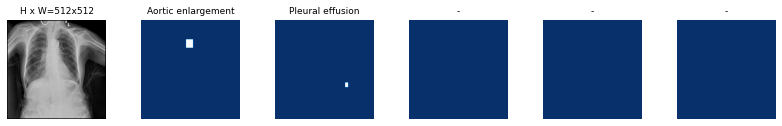

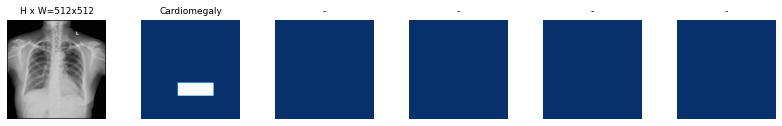

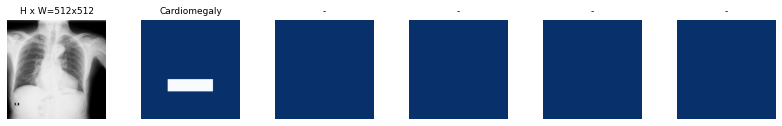

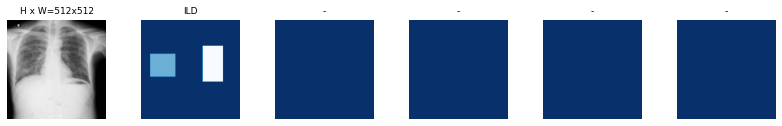

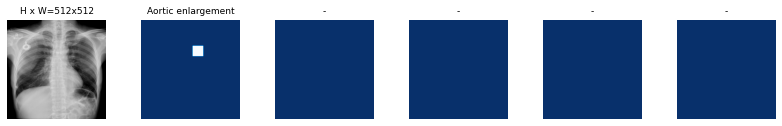

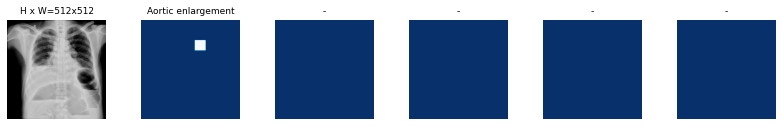

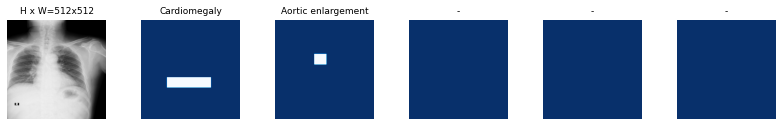

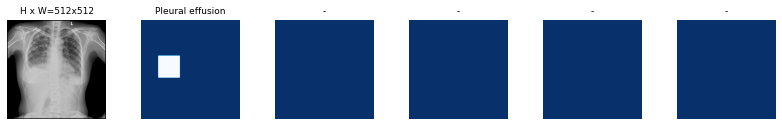

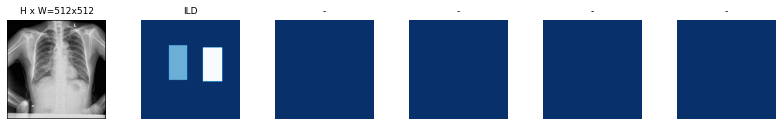

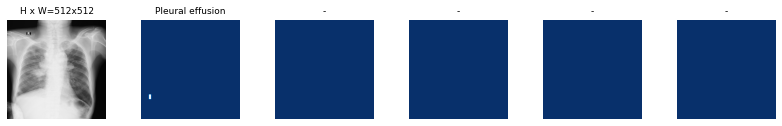

In [26]:
training_percentage = 0.9  #percentage of data to be used for training

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((1-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

for i in range(10):
    image_id = random.choice(train_dataset.image_ids)  #for every loop a random image is chosen.
    image = train_dataset.load_image(image_id)      
    mask, class_ids = train_dataset.load_mask(image_id)
    
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [27]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [28]:
LR = 1e-4
EPOCHS = [1,18]   #best results at epoch=18 or greater than that.

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [29]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[0],
            layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0001

Checkpoint Path: diagnostic20230705T1741/mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed

In [30]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/10,
            epochs=EPOCHS[1],
            layers='all')

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=1e-05

Checkpoint Path: diagnostic20230705T1741/mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

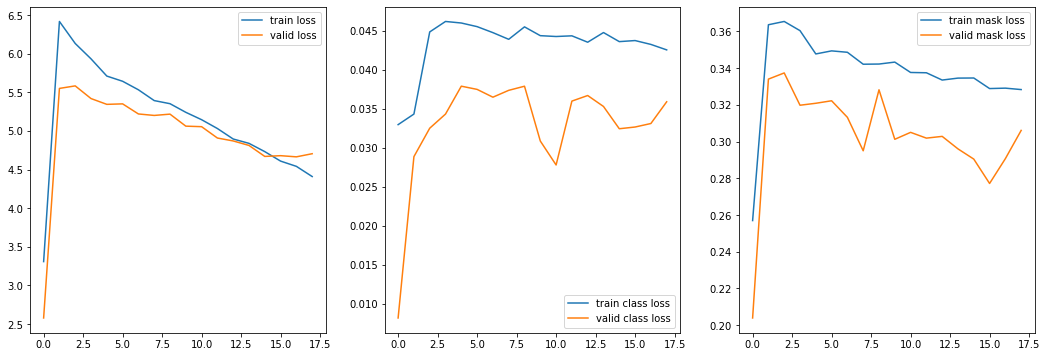

In [31]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [32]:
best_epoch = np.argmin(history["val_loss"][1:]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][1:][best_epoch-1])

Best epoch:  16
Valid loss:  4.664440349110717


# Predict on test images

In [33]:
resized_test_folder = "../../working/resized_test/"
os.mkdir(resized_test_folder)

In [34]:
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir="")

In [35]:
glob_list = glob.glob(f'diagnostic*/mask_rcnn_diagnostic_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

In [36]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# This is done to avoid overlapping region of interests.
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois
#It converts run length encoding representation of binary mask into binary image.
def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

#The annotations are converted into a mask of shape (height, width, num_annotations)
def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape

    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = resized_test_folder+"temp_image.jpg"
    cv2.imwrite(saved_filename, resized_img) 
    img = cv2.imread(saved_filename)

    result = model.detect([img])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'], 
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

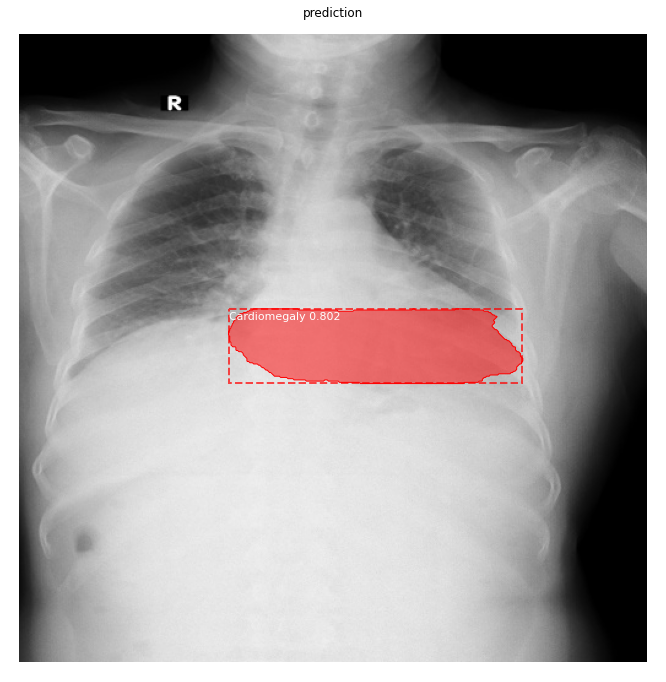

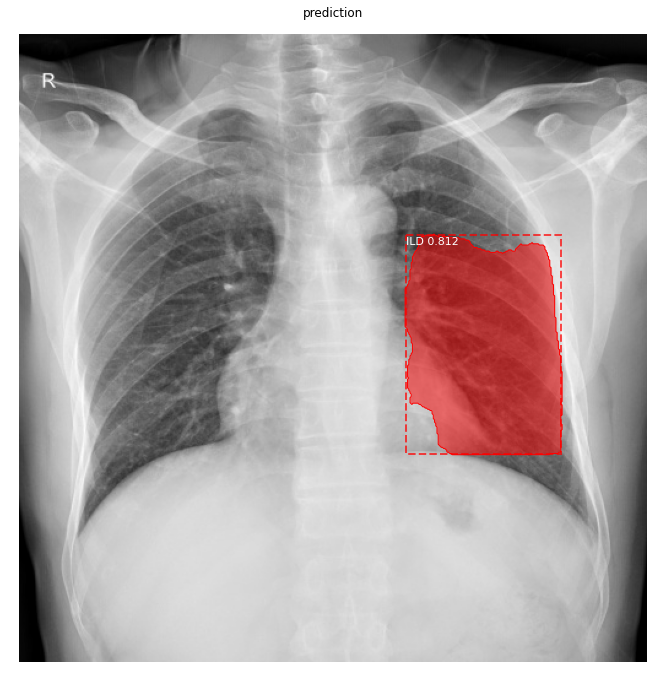


*** No instances to display *** 



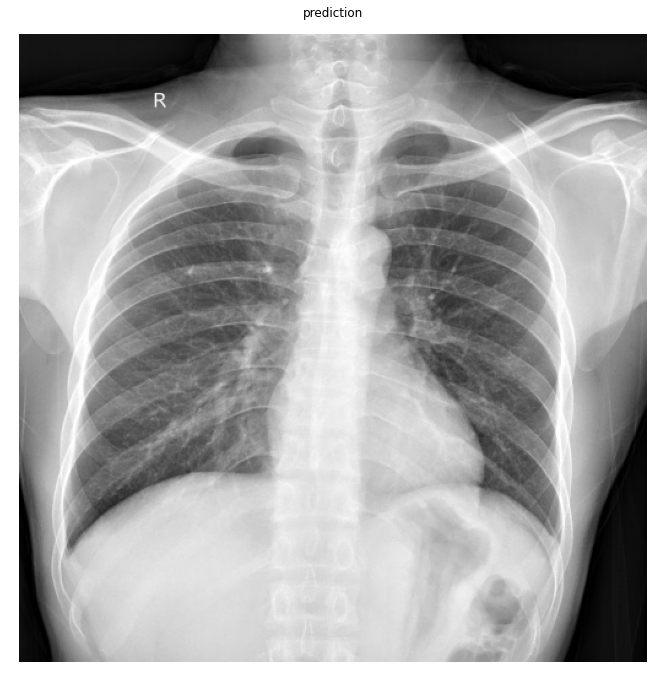

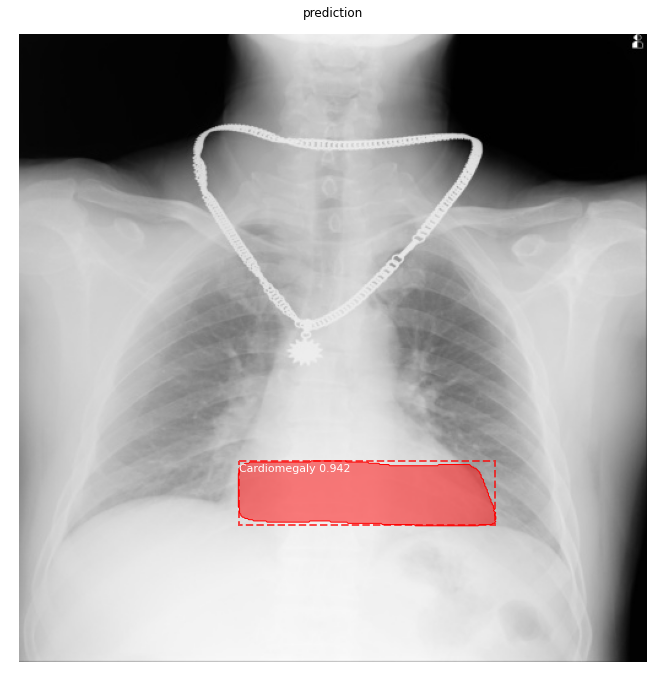


*** No instances to display *** 



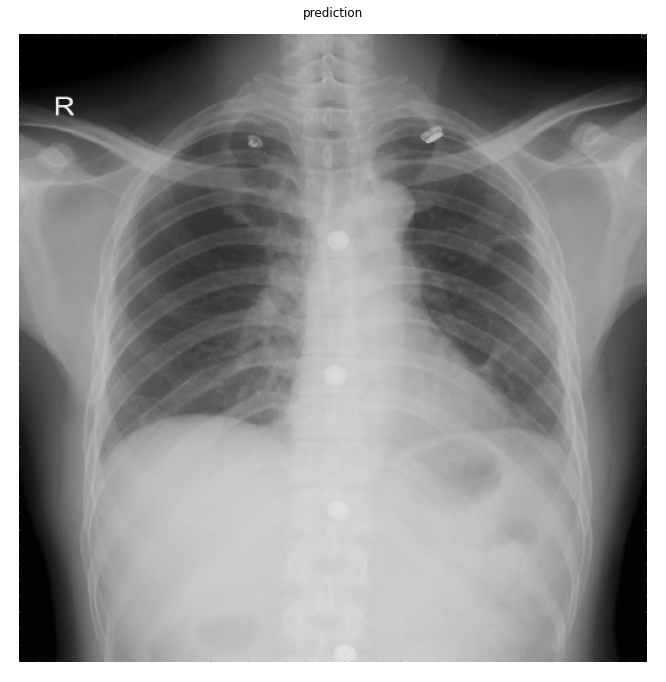

In [37]:
test_folder = "../../input/vinbigdata-chest-xray-abnormalities-detection/test/"
test_file_list = os.listdir(test_folder)[:5]

for test_file in test_file_list:
    dicom_image = read_xray(test_folder+test_file)
    find_anomalies(dicom_image, display=True)